In [1]:
!pip3 install devito sympy==1.8 scikit-image opencv-python somoclu > /dev/null 2>&1
!rm -rf Simple2D/
!mkdir -p Simple2D/
!wget https://github.com/devitocodes/data/raw/master/Simple2D/vp_marmousi_bi --directory-prefix=/content/Simple2D

--2021-05-10 13:34:57--  https://github.com/devitocodes/data/raw/master/Simple2D/vp_marmousi_bi
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/devitocodes/data/master/Simple2D/vp_marmousi_bi [following]
--2021-05-10 13:34:58--  https://raw.githubusercontent.com/devitocodes/data/master/Simple2D/vp_marmousi_bi
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2568004 (2.4M) [application/octet-stream]
Saving to: ‘/content/Simple2D/vp_marmousi_bi’

vp_marmousi_bi      100%[===================>]   2.45M  --.-KB/s    in 0.06s   

2021-05-10 13:34:58 (42.7 MB/s) - ‘/content/Simple2D/vp_marmousi_bi’ save

# Reverse Time Migration

This notebook is the second in a series of tutorial highlighting various aspects of seismic inversion based on Devito operators. In this second example we aim to highlight the core ideas behind seismic inversion, where we create an image of the subsurface from field recorded data. This tutorial follows on the modelling tutorial and will reuse the modelling operator and velocity model.

## Imaging requirement

Seismic imaging relies on two known parameters:

- **Field data** - or also called **recorded data**. This is a shot record corresponding to the true velocity model. In practice this data is acquired as described in the first tutorial. In order to simplify this tutorial we will generate synthetic field data by modelling it with the **true velocity model**.

- **Background velocity model**. This is a velocity model that has been obtained by processing and inverting the field data. We will look at this methods in the following tutorial as it relies on the method we are describing here. This velocity model is usually a **smooth version** of the true velocity model.

## Imaging computational setup

In this tutorial, we will introduce the back-propagation operator. This operator simulates the adjoint wave-equation, that is a wave-equation solved in a reversed time order. This time reversal led to the naming of the method we present here, called Reverse Time Migration. The notion of adjoint in exploration geophysics is fundamental as most of the wave-equation based imaging and inversion methods rely on adjoint based optimization methods.

## Notes on the operators

As we have already described the creation of a forward modelling operator, we will use a thin wrapper function instead. This wrapper is provided by a utility class called `AcousticWaveSolver`, which provides all the necessary operators for seismic modeling, imaging and inversion. The `AcousticWaveSolver` provides a more concise API for common wave propagation operators and caches the Devito `Operator` objects to avoid unnecessary recompilation. Operators introduced for the first time in this tutorial will be properly described.

As before we initialize printing and import some utilities. We also raise the Devito log level to avoid excessive logging for repeated operator invocations.

In [2]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

## Computational considerations

Seismic inversion algorithms are generally very computationally demanding and require a large amount of memory to store the forward wavefield. In order to keep this tutorial as lightweight as possible we are using a very simple
velocity model that requires low temporal and spatial resolution. For a more realistic model, a second set of preset parameters for a reduced version of the 2D Marmousi data set [1] is provided below in comments. This can be run to create some more realistic subsurface images. However, this second preset is more computationally demanding and requires a slightly more powerful workstation.

In [3]:
# Configure model presets
from examples.seismic import demo_model
from examples.seismic.model import SeismicModel

# Enable model presets here:
# preset = 'layers-isotropic'      # A simple but cheap model (recommended)
preset = 'multilayers-isotropic'   # A simple but cheap model (recommended)
# preset = 'circle-isotropic'      # A simple but cheap model (recommended)
# preset = 'triangle-isotropic'    # A simple but cheap model (recommended)
# preset = 'square-isotropic'      # A simple but cheap model (recommended)
# preset = 'marmousi2d-isotropic'  # A larger more realistic model
# preset = 'marmousi-tti2d'        # A larger more realistic model

noisy = False
atenuation = 10

# Standard preset with a simple two-layer model
if preset == 'layers-isotropic' or preset == 'circle-isotropic':
    def create_model(grid=None):
        return demo_model(preset, origin=(0., 0.), shape=(101, 101),
                          spacing=(10., 10.), nbl=20, grid=grid, nlayers=2)
    filter_sigma = (1, 1)
    nshots = 100
    nreceivers = 101
    t0 = 0.
    tn = 1000.  # Simulation last 1 second (1000 ms)
    f0 = 0.015  # Source peak frequency is 10Hz (0.010 kHz)

elif preset == 'triangle-isotropic':
    def create_model(grid=None):
        space_order = 2
        shape = (101, 101)
        spacing = tuple([10. for _ in shape])
        origin = tuple([0. for _ in shape])
        nbl = 10
        dtype = np.float32
        vp = 3.5
        nlayers = 3
        vp_background = 1.5

        v = np.empty(shape, dtype=dtype)
        v[:] = vp_background

        x, y = int(shape[0] / 2), int(shape[1] / 2)
        h = 10
        
        for j in range(0, h*2):
            for i in range(x - int(j/2), x + int(j/2)):
                v[i, y - h - (shape[1] - j)] = 4

        return SeismicModel(space_order=space_order, vp=v, nbl=nbl,
                            dtype=dtype, origin=origin, shape=shape,
                            spacing=spacing)
        
    filter_sigma = (1, 1)
    nshots = 100
    nreceivers = 101
    t0 = 0.
    tn = 1000.  # Simulation last 1 second (1000 ms)
    f0 = 0.015  # Source peak frequency is 10Hz (0.010 kHz)
    n_clusters = 2

elif preset == 'square-isotropic':
    def create_model(grid=None):
        space_order = 2
        shape = (101, 101)
        spacing = tuple([10. for _ in shape])
        origin = tuple([0. for _ in shape])
        nbl = 10
        dtype = np.float32
        vp = 3.5
        nlayers = 3
        vp_background = 1.5

        v = np.empty(shape, dtype=dtype)
        v[:] = vp_background

        x, y = int(shape[0] / 2), int(shape[1] / 2)
        h = 10
        
        v[x - h:x + h, y - h:y + h] = 4

        return SeismicModel(space_order=space_order, vp=v, nbl=nbl,
                            dtype=dtype, origin=origin, shape=shape,
                            spacing=spacing)
        
    filter_sigma = (1, 1)
    nshots = 100
    nreceivers = 101
    t0 = 0.
    tn = 1000.  # Simulation last 1 second (1000 ms)
    f0 = 0.015  # Source peak frequency is 10Hz (0.010 kHz)
    n_clusters = 2

elif preset == 'multilayers-isotropic':
    def create_model(grid=None):
        space_order = 2
        shape = (101, 101)
        spacing = tuple([10. for _ in shape])
        origin = tuple([0. for _ in shape])
        nbl = 10
        dtype = np.float32
        vp = 3.5
        nlayers = 3
        vp_background = 3.5

        v = np.empty(shape, dtype=dtype)
        v[:] = vp_background

        y = int(shape[1] / 3)
        v[:, y:2 * y] = 2.5
        v[:, 2 * y:] = 1.5

        return SeismicModel(space_order=space_order, vp=v, nbl=nbl,
                            dtype=dtype, origin=origin, shape=shape,
                            spacing=spacing)
        
    filter_sigma = (1, 1)
    nshots = 100
    nreceivers = 101
    t0 = 0.
    tn = 1000.  # Simulation last 1 second (1000 ms)
    f0 = 0.015  # Source peak frequency is 10Hz (0.010 kHz)
    n_clusters = 3

# A more computationally demanding preset based on the 2D Marmousi model
elif preset == 'marmousi2d-isotropic':
    def create_model(grid=None):
        return demo_model('marmousi2d-isotropic', data_path='/content',
                          grid=grid, nbl=20)
    filter_sigma = (6, 6)
    nshots = 601  # Need good covergae in shots, one every two grid points
    nreceivers = 601  # One recevier every grid point
    t0 = 0.
    tn = 3500.  # Simulation last 3.5 second (3500 ms)
    f0 = 0.025  # Source peak frequency is 25Hz (0.025 kHz)

# A more computationally demanding preset based on the 2D Marmousi model
elif preset == 'marmousi-tti2d':
    def create_model(grid=None):
        return demo_model('marmousi-tti2d', data_path='/content',
                          grid=grid, nbl=20)
    filter_sigma = (6, 6)
    nshots = 200  # Need good covergae in shots, one every two grid points
    nreceivers = 200  # One recevier every grid point
    t0 = 0.
    tn = 3500.  # Simulation last 3.5 second (3500 ms)
    f0 = 0.025  # Source peak frequency is 25Hz (0.025 kHz)

else:
    raise ValueError("Unable to identify preset.")

# True and smooth velocity models

First, we create the model data for the "true" model from a given demonstration preset. This model represents the subsurface topology for the purposes of this example and we will later use it to generate our synthetic data readings. We also generate a second model and apply a smoothing filter to it, which represents our initial model for the imaging algorithm. The perturbation between these two models can be thought of as the image we are trying to recover.

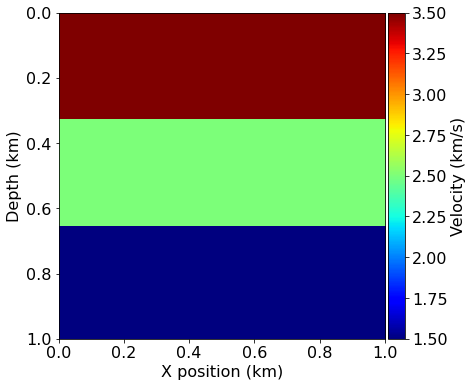

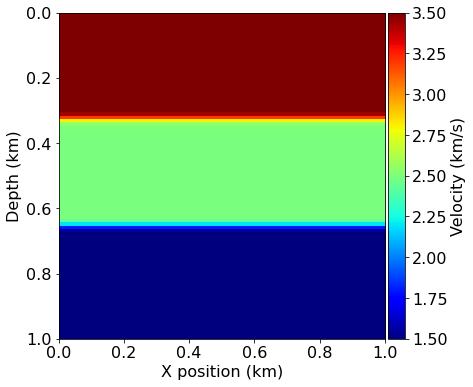

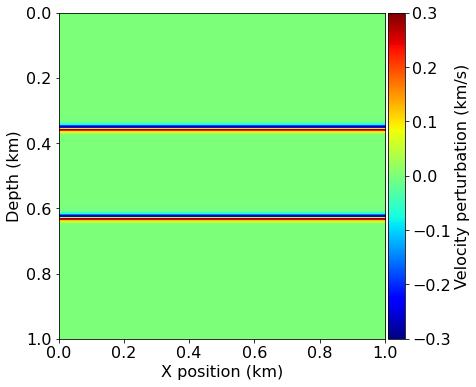

In [4]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_velocity, plot_perturbation
from devito import gaussian_smooth

# Create true model from a preset
model = create_model()

# Create initial model and smooth the boundaries
model0 = create_model(grid=model.grid)
gaussian_smooth(model0.vp, sigma=filter_sigma)

# Plot the true and initial model and the perturbation between them
plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

## Acquisition geometry

Next we define the positioning and the wave signal of our source, as well as the location of our receivers. To generate the wavelet for our source we require the discretized values of time that we are going to use to model a single "shot",
which again depends on the grid spacing used in our model. For consistency this initial setup will look exactly as in the previous modelling tutorial, although we will vary the position of our source later on during the actual imaging algorithm.

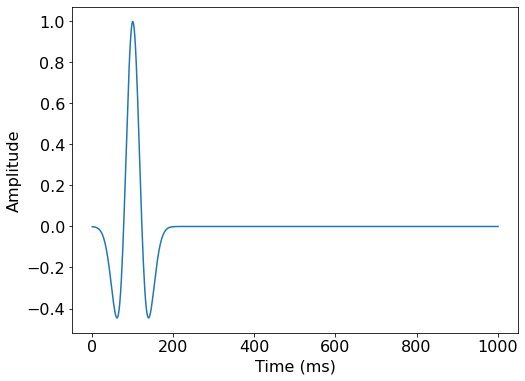

In [5]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 30.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=.010, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

# True and smooth data

We can now generate the shot record (receiver readings) corresponding to our true and initial models. The difference between these two records will be the basis of the imaging procedure.

For this purpose we will use the same forward modelling operator that was introduced in the previous tutorial, provided by the `AcousticWaveSolver` utility class. This object instantiates a set of pre-defined operators according to an initial definition of the acquisition geometry, consisting of source and receiver symbols. The solver objects caches the individual operators and provides a slightly more high-level API that allows us to invoke the modelling modelling operators from the initial tutorial in a single line. In the following cells we use this to generate shot data by only specifying the respective model symbol `m` to use, and the solver will create and return a new `Receiver` object the represents the readings at the previously defined receiver coordinates.  

In [6]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d , _, _ = solver.forward(vp=model.vp)

Re-initializing damp profile from mask to damp
Model has to be created with `bcs="damp"`for this WaveSolver


In [7]:
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=model0.vp)

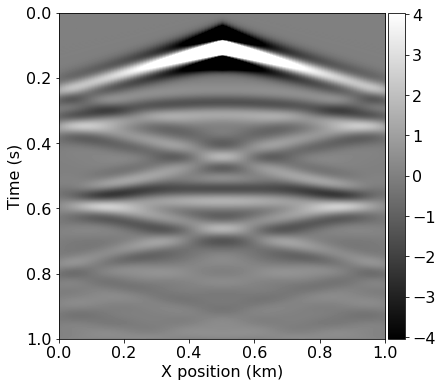

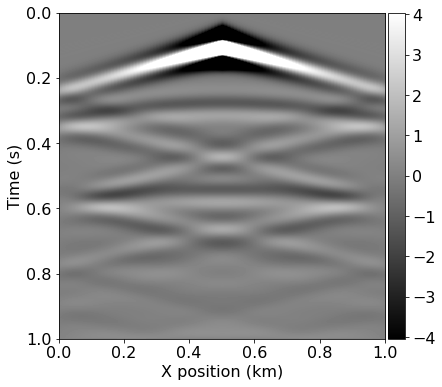

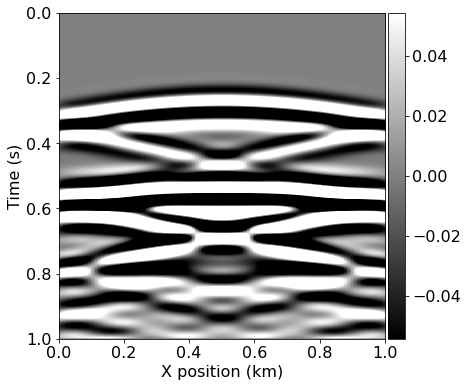

In [8]:
#NBVAL_IGNORE_OUTPUT
# Plot shot record for true and smooth velocity model and the difference
from examples.seismic import plot_shotrecord

plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

# Imaging with back-propagation

As explained in the introduction of this tutorial, this method is based on back-propagation. 

## Adjoint wave equation

If we go back to the modelling part, we can rewrite the simulation as a linear system solve:

\begin{equation}
\mathbf{A}(\mathbf{m}) \mathbf{u} = \mathbf{q}
\end{equation}

where $\mathbf{m}$ is the discretized square slowness, $\mathbf{q}$ is the discretized source and $\mathbf{A}(\mathbf{m})$ is the discretized wave-equation. The discretized wave-equation matricial representation is a lower triangular matrix that can be solve with forward substitution. The pointwise writing or the forward substitution leads to the time-stepping stencil.

On a small problem one could form the matrix explicitly and transpose it to obtain the adjoint discrete wave-equation:

\begin{equation}
\mathbf{A}(\mathbf{m})^T \mathbf{v} = \delta \mathbf{d}
\end{equation}

where $\mathbf{v}$ is the discrete **adjoint wavefield** and  $\delta \mathbf{d}$ is the data residual defined as the difference between the field/observed data and the synthetic data $\mathbf{d}_s = \mathbf{P}_r \mathbf{u}$. In our case we derive the discrete adjoint wave-equation from the discrete forward wave-equation to get its stencil. 

## Imaging

Wave-equation based imaging relies on one simple concept:

- If the background velocity model is cinematically correct, the forward wavefield $\mathbf{u}$ and the adjoint wavefield $\mathbf{v}$ meet at the reflectors position at zero time offset. 

The sum over time of the zero time-offset correlation of these two fields then creates an image of the subsurface. Mathematically this leads to the simple imaging condition:

\begin{equation}
  \text{Image} = \sum_{t=1}^{n_t} \mathbf{u}[t] \mathbf{v}[t]
\end{equation}

In the following tutorials we will describe a more advanced imaging condition that produces shaper and more accurate results.

## Operator

We will now define the imaging operator that computes the adjoint wavefield $\mathbf{v}$ and correlates it with the forward wavefield $\mathbf{u}$. This operator essentially consists of three components:
* Stencil update of the adjoint wavefield `v`
* Injection of the data residual at the adjoint source (forward receiver) location
* Correlation of `u` and `v` to compute the image contribution at each timestep

In [9]:
# Define gradient operator for imaging
from devito import TimeFunction, Operator, Eq, solve
from examples.seismic import PointSource

def ImagingOperator(model, image):
    # Define the wavefield with the size of the model and the time dimension
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4)

    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=4,
                     save=geometry.nt)
    
    # Define the wave equation, but with a negated damping term
    eqn = model.m * v.dt2 - v.laplace + model.damp * v.dt.T

    # Use `solve` to rearrange the equation into a stencil expression
    stencil = Eq(v.backward, solve(eqn, v.backward))
    
    # Define residual injection at the location of the forward receivers
    dt = model.critical_dt
    residual = PointSource(name='residual', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions)    
    res_term = residual.inject(field=v.backward, expr=residual * dt**2 / model.m)

    # Correlate u and v for the current time step and add it to the image
    image_update = Eq(image, image - u * v)

    return Operator([stencil] + res_term + [image_update],
                    subs=model.spacing_map)

## Implementation of the imaging loop

As just explained, the forward wave-equation is solved forward in time while the adjoint wave-equation is solved in a reversed time order. Therefore, the correlation of these two fields over time requires to store one of the two fields. The computational procedure for imaging follows:

- Simulate the forward wave-equation with the background velocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the image contribution at each time step. 

This procedure is applied to multiple source positions (shots) and summed to obtain the full image of the subsurface. We can first visualize the varying locations of the sources that we will use. 

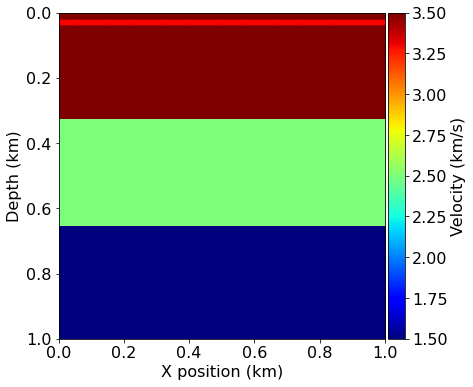

In [10]:
#NBVAL_IGNORE_OUTPUT
if preset == 'marmousi2d-isotropic':
    nrange = 7500.
else:
    nrange = 1000.

# Prepare the varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., nrange, num=nshots)
source_locations[:, 1] = 30.

plot_velocity(model, source=source_locations)

In [11]:
# Run imaging loop over shots
from devito import Function

# Create image symbol and instantiate the previously defined imaging operator
image = Function(name='image', grid=model.grid)
op_imaging = ImagingOperator(model, image)

for i in range(nshots):
    print('Imaging source %d out of %d' % (i+1, nshots))
    
    # Update source location
    geometry.src_positions[0, :] = source_locations[i, :]

    # Generate synthetic data from true model
    true_d, _, _ = solver.forward(vp=model.vp)
    
    # Compute smooth data and full forward wavefield u0
    smooth_d, u0, _ = solver.forward(vp=model0.vp, save=True)
    
    # Compute gradient from the data residual  
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4)
    residual = smooth_d.data - true_d.data
    op_imaging(u=u0, v=v, vp=model0.vp, dt=model0.critical_dt, 
               residual=residual)
    
    # Force garbage collection due to high memory usage
    del true_d
    del smooth_d
    del u0
    del v


Imaging source 1 out of 100
Imaging source 2 out of 100
Imaging source 3 out of 100
Imaging source 4 out of 100
Imaging source 5 out of 100
Imaging source 6 out of 100
Imaging source 7 out of 100
Imaging source 8 out of 100
Imaging source 9 out of 100
Imaging source 10 out of 100
Imaging source 11 out of 100
Imaging source 12 out of 100
Imaging source 13 out of 100
Imaging source 14 out of 100
Imaging source 15 out of 100
Imaging source 16 out of 100
Imaging source 17 out of 100
Imaging source 18 out of 100
Imaging source 19 out of 100
Imaging source 20 out of 100
Imaging source 21 out of 100
Imaging source 22 out of 100
Imaging source 23 out of 100
Imaging source 24 out of 100
Imaging source 25 out of 100
Imaging source 26 out of 100
Imaging source 27 out of 100
Imaging source 28 out of 100
Imaging source 29 out of 100
Imaging source 30 out of 100
Imaging source 31 out of 100
Imaging source 32 out of 100
Imaging source 33 out of 100
Imaging source 34 out of 100
Imaging source 35 out o

Time to plot the image and adding some noise if necessary. It is important to understand if the attribute is capable to reduce disturbances from the signal.

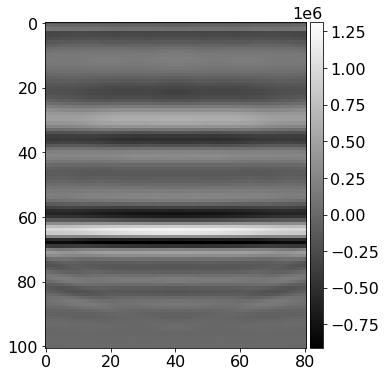

In [12]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_image

noisy = False

if noisy:
    signal = np.mean(image.data) / atenuation
    noise = np.random.normal(0, signal, image.data.shape)
    new_image = image.data + noise
else:
    new_image = image.data

# Plot the inverted image
plot_image(np.diff(new_image, axis=1)[20:new_image.shape[0] - 20,10:new_image.shape[0] - 10])

In [13]:
from devito import norm
print(norm(image), 1e7)
assert np.isclose(norm(image), 1e7, rtol=1e1)

105889070.0 10000000.0


And we have an image of the subsurface with a strong reflector at the original location.

# Attributes Calculation and Selection

Now, let's calculate some attributes of the subsurface image generated with devito. The project selected was `d2geo`. It is possible to calculate some Complex and Signal attributes of the seismic data.

In [14]:
!pip install sklearn dask fsspec>=0.3.3
!rm -rf d2geo
!git clone https://github.com/jcfaracco/d2geo.git

Cloning into 'd2geo'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 116 (delta 29), reused 20 (delta 3), pack-reused 52
Receiving objects: 100% (116/116), 52.90 KiB | 6.61 MiB/s, done.
Resolving deltas: 100% (55/55), done.


Amplitude


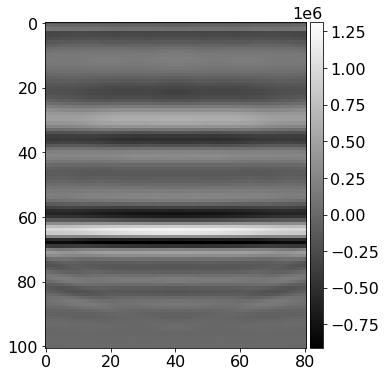

Envelope


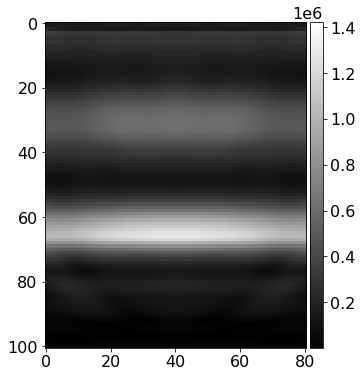

Instantaneous Phase


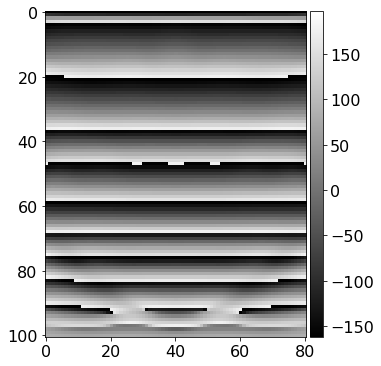

Instantaneous Frequency


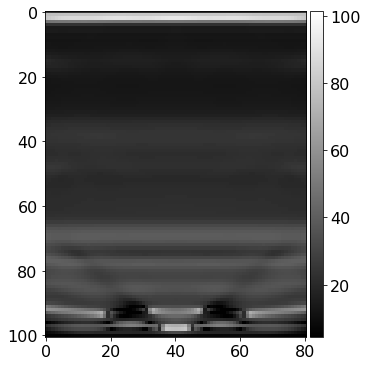

Instantaneous Bandwidth


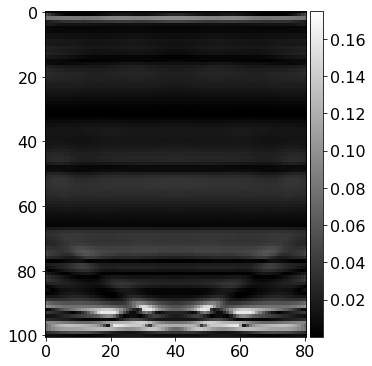

Dominant Frequency


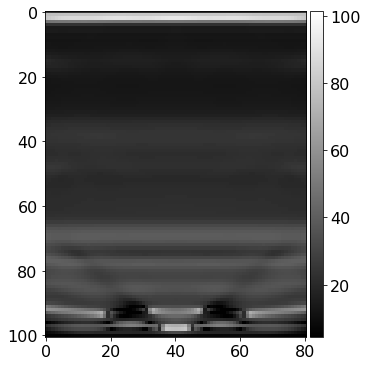

Cosine Instantaneous Phase


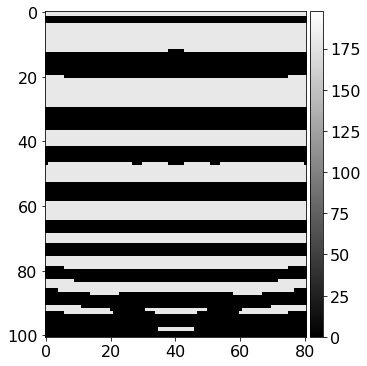

Relative Amplitude Change


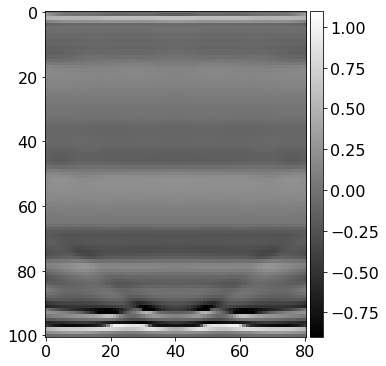

First Derivative


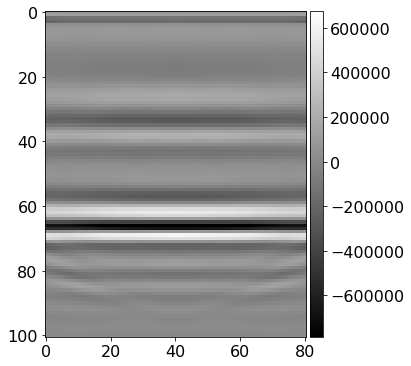

Second Derivative


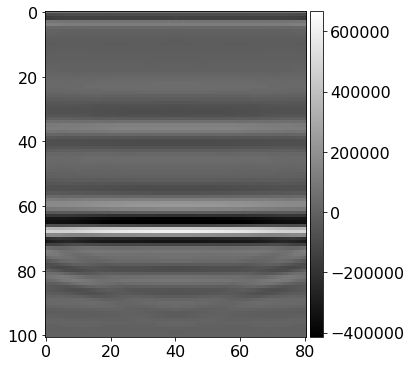

Time Gain


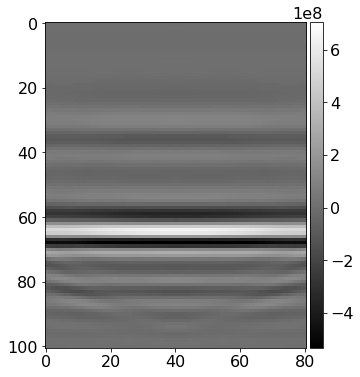

Reflection Intensity


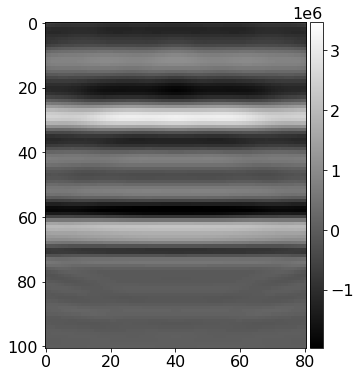

Frequency Change


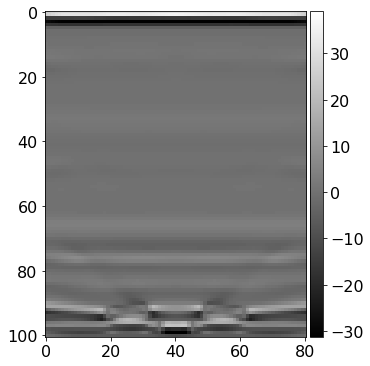

Sweetness


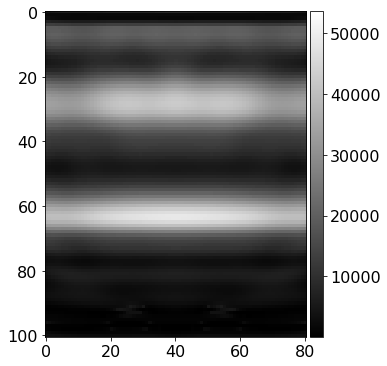

Response Phase


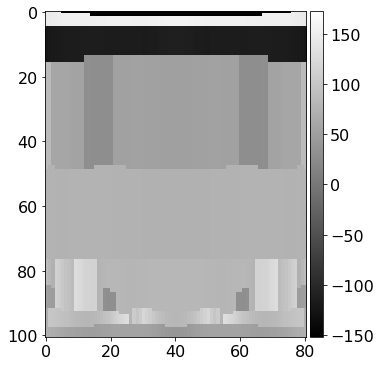

Response Frequency


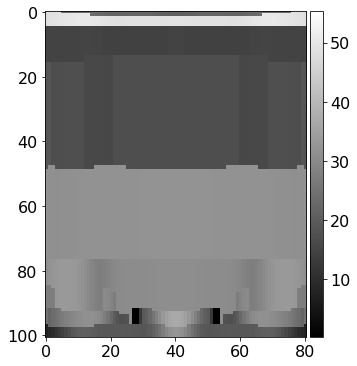

Response Amplitude


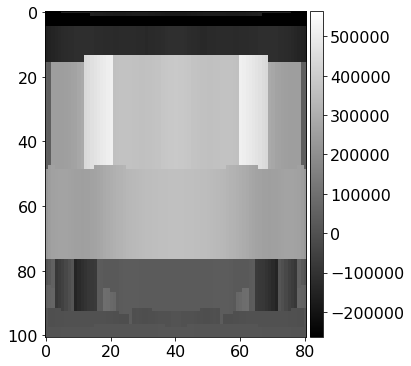

In [15]:
import cv2
import sys

# Dataframe libraries for attribute computation.
import dask.array as da
import dask.dataframe as ddf

import skimage
from skimage.filters.rank import entropy
from skimage.morphology import disk

from typing import Dict, List, Tuple, Callable

sys.path.append('./d2geo/attributes')

from d2geo.attributes.CompleTrace import ComplexAttributes
from d2geo.attributes.SignalProcess import SignalProcess
from d2geo.attributes.DipAzm import DipAzm

complex_att = ComplexAttributes()
signal_process = SignalProcess()
dip_azm = DipAzm()

def amplitude_arr(input_cube):
    return da.from_array(input_cube)

def run_attributes(input_cube, attributes: List[Tuple[str, Callable, Dict[str, str]]]):
    datas = [attr_func(input_cube, **attr_kwargs).flatten() for _, attr_func, attr_kwargs in attributes]
    datas = da.stack(datas, axis=1)
    return ddf.from_dask_array(datas, columns=[attr_name for attr_name, _, _ in attributes])

# List of tuples with attribute name, the function 
# to run (with cube as input) and additional kwargs dict.
# If you would like to remove some attribute just comment.
funcs = [
    ('Amplitude', amplitude_arr, {}),
    ('Envelope', complex_att.envelope, {}),
    ('Instantaneous Phase', complex_att.instantaneous_phase, {}),
    ('Instantaneous Frequency', complex_att.instantaneous_frequency, {}),
    ('Instantaneous Bandwidth', complex_att.instantaneous_bandwidth, {}),
    ('Dominant Frequency', complex_att.dominant_frequency, {}),
    ('Cosine Instantaneous Phase', complex_att.cosine_instantaneous_phase, {}),
    ('Relative Amplitude Change', complex_att.relative_amplitude_change, {}),
    ('First Derivative', signal_process.first_derivative, {}),
    ('Second Derivative', signal_process.second_derivative, {}),
    ('Time Gain', signal_process.time_gain, {}),
#    ('Dip GST', dip_azm.gst_3D_dip, {}),
#    ('Azm GST', dip_azm.gst_3D_azm, {}),
    ('Reflection Intensity', signal_process.reflection_intensity, {}),
#    ('Quality Factor', complex_att.quality_factor, {}),
#    ('Apparent Polarity', complex_att.apparent_polarity, {}),
    ('Frequency Change', complex_att.frequency_change, {}),
    ('Sweetness', complex_att.sweetness, {}),
    ('Response Phase', complex_att.response_phase, {}),
    ('Response Frequency', complex_att.response_frequency, {}),
    ('Response Amplitude', complex_att.response_amplitude, {})
]

facie = np.diff(new_image, axis=1)[20:new_image.shape[0] - 20,10:new_image.shape[0] - 10]
x = facie.shape[0]
y = facie.shape[1]

facies = np.empty((0, x, y))
for i in range(10):
    facies = np.append(facies, [facie], axis=0)

dataframe = run_attributes(facies, funcs).compute()
dataframe.tail()

# Plot and remove unselected attribute if it is not present
delete_list = []
att_list = [x[0] for x in funcs]
for att in att_list:
    try:
        image_att = dataframe[att].values.reshape((10, x, y))
        print(att)
        plot_image(image_att[0, :, :], cmap='gray')
    except KeyError:
        print("There is no data for %s" % att)
        delete_list.append(att)

The next step is plot each attribute as a kind of wave signal. It is important to see the behavior of the wave to understand if the attribute is interesting todo the facie classification properly. This method is similar to compare well logs with each facie.

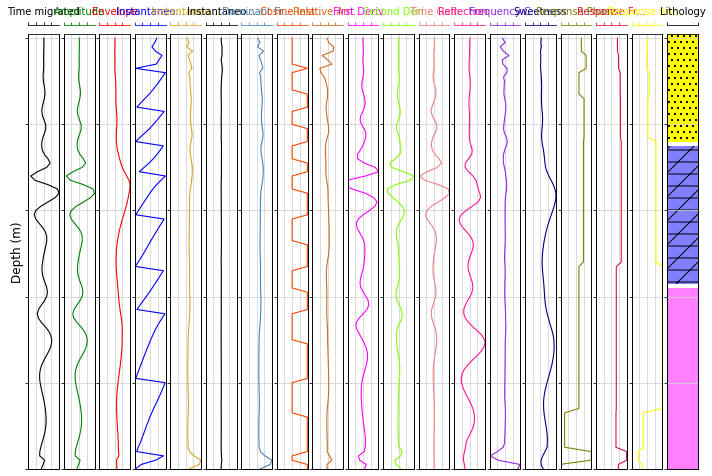

In [16]:
import matplotlib.pyplot as plt

lithology_numbers = {1.5: {'lith':'Sandstone', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                     1.75: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                     2.0: {'lith':'Shale', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                     2.25: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                     2.5: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                     2.75: {'lith':'Limestone', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                     3.0: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                     3.25: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                     3.5: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                     3.75: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                     4.0: {'lith':'Coal', 'lith_num':11, 'hatch':'', 'color':'black'},
                     4.25: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'},
                     4.5: {'lith':'Basement', 'lith_num':13, 'hatch':'O', 'color':'#80aaff'}}

def makeray(ax, ray, xlabel, ylabel, color):
    if len(xlabel) > 14:
        xlabel = xlabel[0:11] + "..."
    s0 = int(-np.amax(ray)) - 2
    s1 = int(np.amax(ray)) + 2
    step = (s1 - s0) / 4
    ax.plot(ray, np.arange(len(ray)), color=color, linewidth=1.1)
    ax.set_xlabel(xlabel)
    ax.xaxis.label.set_color(color)
    ax.xaxis.label.set_size(10)
    ax.yaxis.label.set_size(12)
    ax.set_xlim(s0, s1)
    ax.set_xticklabels([])
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.grid(True)
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', colors=color)
    ax.spines["top"].set_edgecolor(color)
    ax.title.set_color(color)
    ax.set_xticks(np.arange(start=s0, stop=s1, step=step))    

def makeplot(origin, rays, color_list, xlabels, ylabel, bottom_depth, top_depth):
    fig, ax = plt.subplots(figsize=(12,8))

    nrays = len(rays)

    #Set up the plot axes
    ax = []
    ax.append(plt.subplot2grid((1, nrays + 1), (0, 0), rowspan=1, colspan=1))

    for i in range(nrays):
        ax.append(plt.subplot2grid((1, nrays + 1), (0, i + 1), rowspan=1, colspan=1, sharey=ax[0]))

    ax_t = []
    for i in range(nrays + 1):
        ax_t.append(ax[i].twiny())
        ax_t[i].xaxis.set_visible(False)

    if len(color_list) < nrays:
        raise ValueError('Color List and Rays should be the same size: (%d, %d).' % (len(color_list), nrays))

    for i in range(nrays):
        if i > 0:
            ylabel = None
        makeray(ax[i], rays[i], xlabels[i], ylabel, color_list[i])

    ax[-1].plot(origin, np.arange(len(origin)), color = "black", linewidth = 0.5)
    ax[-1].set_xlabel("Lithology")
    ax[-1].xaxis.label.set_size(10)
    ax[-1].set_xticklabels([])
    ax[-1].set_xlim(0, 1)
    ax[-1].xaxis.label.set_color("black")
    ax[-1].tick_params(axis='x', colors="black")
    ax[-1].spines["top"].set_edgecolor("black")

    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        
        ax[-1].fill_betweenx(np.arange(len(origin)), 0, origin, where=(origin==key),
                             facecolor=color, hatch=hatch)

    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax_i in ax:
        ax_i.set_ylim(bottom_depth, top_depth)
        ax_i.grid(which='major', color='lightgrey', linestyle='-')
        ax_i.xaxis.set_ticks_position("top")
        ax_i.xaxis.set_label_position("top")
        ax_i.spines["top"].set_position(("axes", 1.02))
        
    for ax_i in ax:
        plt.setp(ax_i.get_yticklabels(), visible = False)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

# If you want to obtain another
# ray change the index. We are 
# getting the middle of the data
slice_idx = int(model.vp.data.shape[0] / 2)

origin = model.vp.data[slice_idx, :]
size = dataframe[att_list[0]].values.reshape((10, x, y))[0, slice_idx, :].shape[0]
rays = [facie[slice_idx, :]]
labels = ["Time migrated"]
for att in att_list:
    try:
        rays.append(dataframe[att].values.reshape((10, x, y))[0, slice_idx, :])
        labels.append(att)
    except KeyError:
        pass

color_list = ["black", "green", "red", "blue", "goldenrod", "black", "steelblue",
              "orangered", "chocolate", "magenta", "chartreuse", "lightcoral", "deeppink",
              "blueviolet", "navy", "olive", "crimson", "yellow", "slategray",
              "lime", "darkorchid", "brown"]

makeplot(origin, rays=rays, color_list=color_list, xlabels=labels, ylabel="Depth (m)", top_depth=size, bottom_depth=0)

Now, let's plot the wiggle of the original time migrated image based on devito calculation.

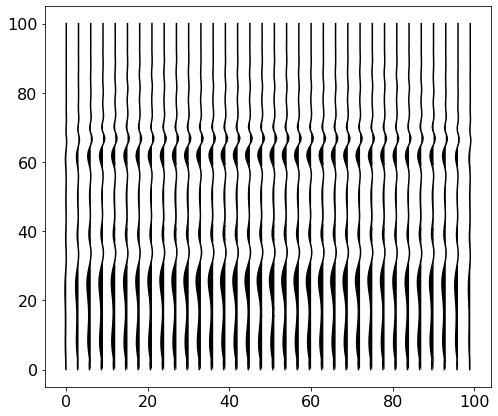

In [17]:
def plot_wiggle(ax, x, t, xoffset=0, posColor='red',
                negColor='blue', alpha=0.5, **kwargs):

    wiggle, = ax.plot(x + xoffset, t, color='black')

    # Invert Y-axis
    ax.set_ylim(ax.get_ylim()[::-1])

    if len(t) > 1:
        tracefill = np.array(x)
        tracefill[0] = 0.0
        tracefill[-1] = 0.0
        tracefill[np.nonzero(x > x[0])] = 0
        fill, = ax.fill(tracefill + xoffset, t, color=negColor,
                        alpha=alpha, linewidth=0)

        tracefill = np.array(x)
        tracefill[0] = 0.0
        tracefill[-1] = 0.0
        tracefill[np.nonzero(x < x[0])] = 0
        fill, = ax.fill(tracefill + xoffset, t, color=posColor,
                        alpha=alpha, linewidth=0)
        
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1)
wiggles = new_image[10:new_image.shape[0] - 10,10:new_image.shape[0] - 10] / (2 * np.amax(facie))
size = wiggles.shape[0]
# Print each wiggle signal with step 3
step = 3
for i in range(0, size, step):
    plot_wiggle(ax, wiggles[i, :], np.arange(0, size), xoffset=i, posColor='black', negColor='black', alpha=1)
plt.show()

# Machine Learning Methods to Classify Facies

Initially, [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) was selected to indentify the facies associated with the original model created at step one of this notebook. Based on attributes collected from the synthethic model. The version used here is provided by the [scikit](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) framework.

Using attributes:
-> Amplitude
-> Envelope
-> Instantaneous Phase
-> Instantaneous Frequency
-> Instantaneous Bandwidth
-> Dominant Frequency
-> Cosine Instantaneous Phase
-> Relative Amplitude Change
-> First Derivative
-> Second Derivative
-> Time Gain
-> Reflection Intensity
-> Frequency Change
-> Sweetness
-> Response Phase
-> Response Frequency
-> Response Amplitude



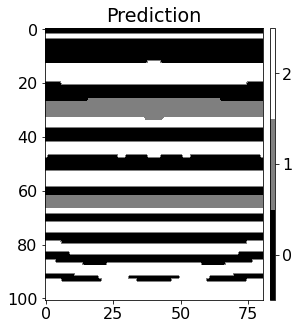

In [18]:
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_slice(slice, title=None, cmap='gray', img_scale=0.015, interpolation='bicubic', is_discrete=False):
    img_h = int(slice.shape[0] * img_scale)
    img_w = int(slice.shape[1] * img_scale)    

    plt.figure(figsize=(5, 5))
    if title: plt.title(title)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.1)
    
    if is_discrete:
        cmap = plt.get_cmap(cmap, np.max(slice)-np.min(slice)+1)
        im = ax.imshow(slice, cmap=cmap, interpolation=None, vmin = np.min(slice)-.5, vmax = np.max(slice)+.5)
        plt.colorbar(im, cax=cax, ticks=np.arange(np.min(slice),np.max(slice)+1))
    else:        
        im = ax.imshow(slice, cmap=cmap, interpolation=interpolation)
        plt.colorbar(im, cax=cax);

norm_dataframe = (dataframe - dataframe.mean())/dataframe.std(ddof=0)

print("Using attributes:")
for att in list(norm_dataframe.columns):
    print("->", att)
print()


kmeans = KMeans(n_clusters=n_clusters, random_state=0)

pred = kmeans.fit_predict(norm_dataframe)

data = pred.reshape(10, x, y)[0, :, :]

plot_slice(np.rot90(data, 3), title='Prediction', cmap='gray', interpolation=None, is_discrete=True)

The second algorithm used is [Kohonen's Self-Organizing Map](https://en.wikipedia.org/wiki/Self-organizing_map) (aka SOM) which is widely used to facies classification techniques. The framework uses here is [Somoclu](https://somoclu.readthedocs.io/en/stable/) because it has several functions related to data visualization and clustering. It has a nice performance also compared with other implementations in Python and it has GPU support if it is compiled with the proper flags.

To clusterize the SOM BMUs, the algorithm which gives the best performance is K-Means also. DBSCAN usually recognizes the classes, but it has a poor performance in some cases of adjacent clusters.

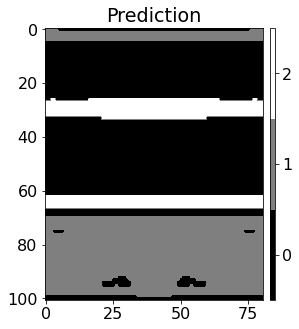

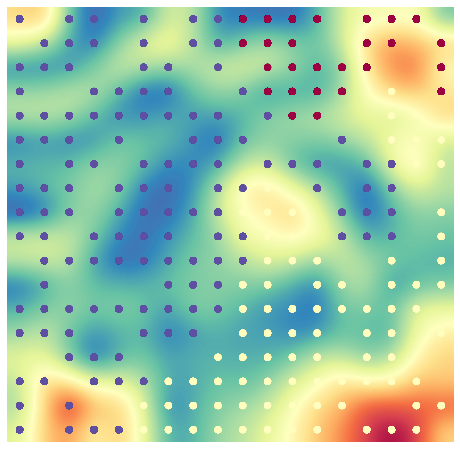

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [19]:
import somoclu
from sklearn.cluster import KMeans

algorithm = KMeans(n_clusters)

def predict(som_model, data):
    W = som_model.codebook.reshape((som_model.codebook.shape[0] * som_model.codebook.shape[1], som_model.codebook.shape[2]))
    X = data

    D = -2*np.dot(W, X.T) + (W**2).sum(1)[:, None] + (X**2).sum(1)[:, None].T
    BMU = (D==D.min(0)[None,:]).astype("float32").T
    NBMU =  BMU.reshape((X.shape[0], som_model.codebook.shape[0], som_model.codebook.shape[1]))
    return np.vstack(NBMU.nonzero()[1:][::-1]).T

def convert_coords(data, n_rows):
    new_data = []
    i = 0
    for item in data:
        x, y = item
        new_data.append(som.clusters[y, x])
    return np.array(new_data)

n_rows, n_columns = 18, 18
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, initialization="pca")

som.train(norm_dataframe.to_numpy())

som.cluster(algorithm=algorithm)

data = predict(som, norm_dataframe.to_numpy())
data = convert_coords(data, n_rows)

pred = data.reshape(10, x, y)[0, :, :]

plot_slice(np.rot90(pred, 3), title='Prediction', cmap='gray', interpolation=None, is_discrete=True)

som.view_umatrix(bestmatches=True)

## References

[1] _Versteeg, R.J. & Grau, G. (eds.) (1991): The Marmousi experience. Proc. EAGE workshop on Practical Aspects of Seismic Data Inversion (Copenhagen, 1990), Eur. Assoc. Explor. Geophysicists, Zeist._